In [30]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget, ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import glob
import torch.nn as nn
from torch.utils.data import DataLoader
from skimage import exposure

In [72]:
# Load the image using PIL
images = glob.glob('../outputs/images/*/*')
sample_images = np.random.choice(images, size=32)

preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_batch = []
for each in sample_images:
    image = Image.open(each).convert("L").resize((256, 256))
    img = np.array(image)
    img = (((img - img.min()) / img.max() - img.min())*255).astype(np.uint8)
    # Stack the Gray scaled 1 channel image 3 times to convert to 3 channel image
    img = np.stack((img, )*3) 
    img = np.transpose(img, (1, 2, 0))
    input_tensor = preprocess(img)
    input_batch.append(input_tensor.unsqueeze(0))

In [73]:
input_batch[0].shape

torch.Size([1, 3, 256, 256])

In [83]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Load a pre-trained Deep Learning model (e.g., ResNet50)
DENSENET121 = models.densenet121()
DENSENET121.classifier = nn.Sequential(
        nn.Linear(in_features=(DENSENET121.classifier.in_features),out_features=512),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=512,out_features=256),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=256,out_features=128),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=128,out_features=2)
    )
model = DENSENET121
model = model.to(device)
model_config = torch.load('../models/V0/densenet121/2023-06-30 10:50:46.047269/best_model_config.pth.tar', map_location='cuda:3')
model.load_state_dict(model_config['model_weights'])
model.eval()
model.features.denseblock4.denselayer16.eval()

cams = []
counter = 0
images_tensor = []
for each in input_batch:
    rgb_img = Image.open(sample_images[counter]).resize((256, 256))
    rgb_img = np.array(rgb_img)
    rgb_img = ((rgb_img - rgb_img.min()) / rgb_img.max() - rgb_img.min())

    targets = [ClassifierOutputTarget(1)]
    #target_layers = [model.features.denseblock4.denselayer16.conv1, model.features.denseblock4.denselayer16.norm2]
    target_layers = [model.features.denseblock4.denselayer16.conv1]

    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=each.to(device), targets=targets)
        cam_image = show_cam_on_image(np.array(rgb_img), grayscale_cams[0, :], use_rgb=True)
        cams.append(cam_image)
    
    images_tensor.append(each[0, 0, :, :])
    counter += 1

In [84]:
print(len(cams))
print(len(images_tensor))

32
32


/tmp/ipykernel_330169/2125696600.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))


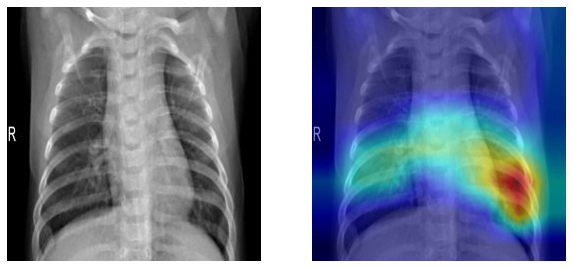

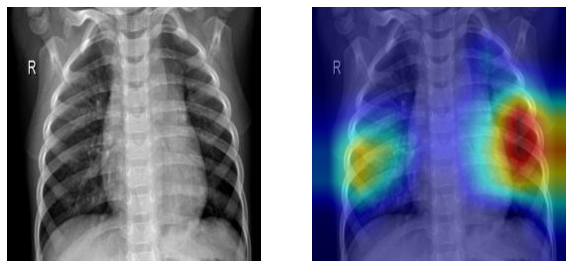

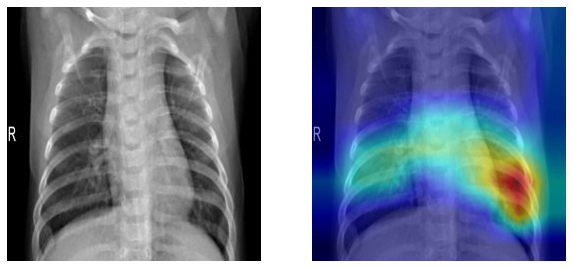

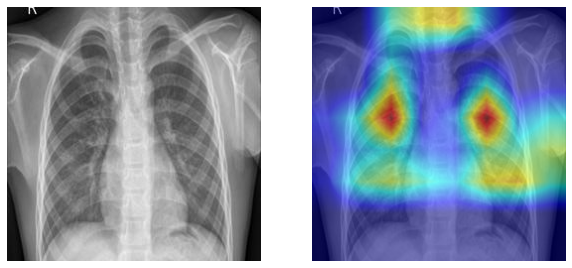

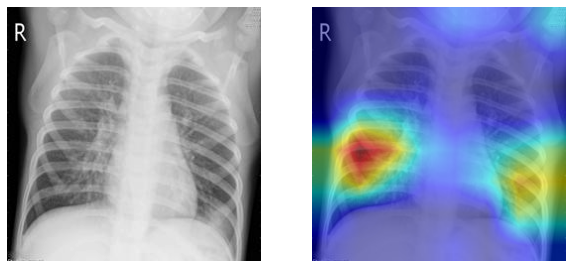

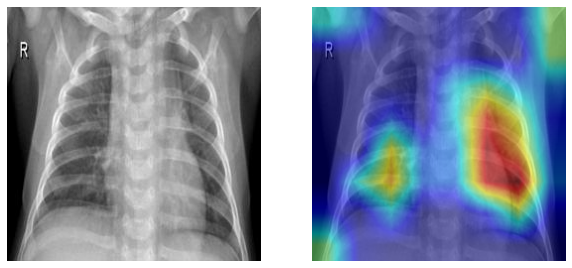

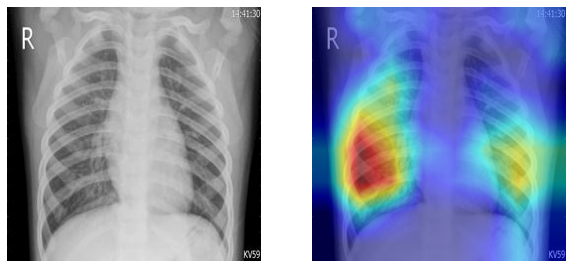

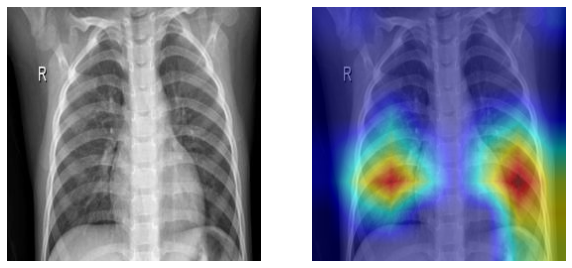

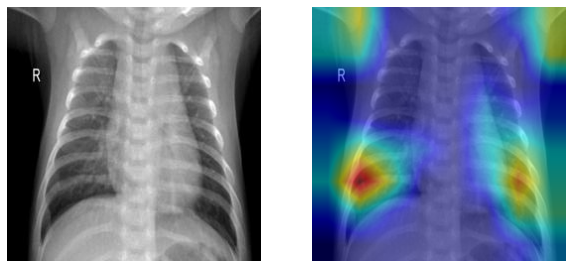

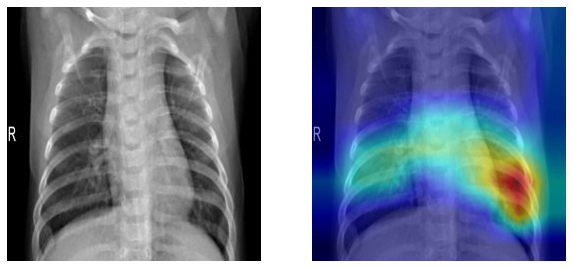

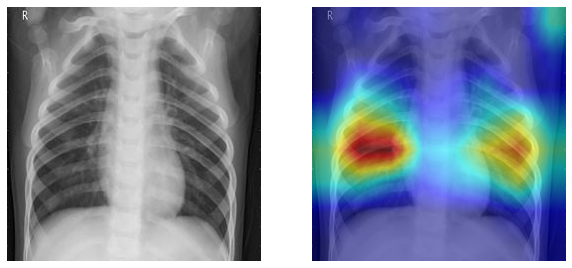

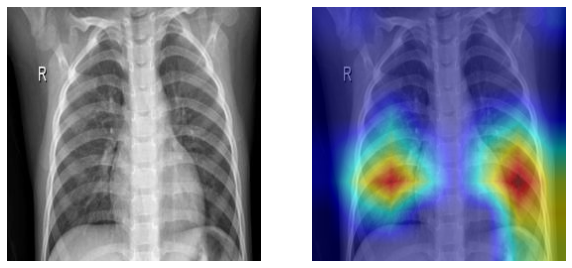

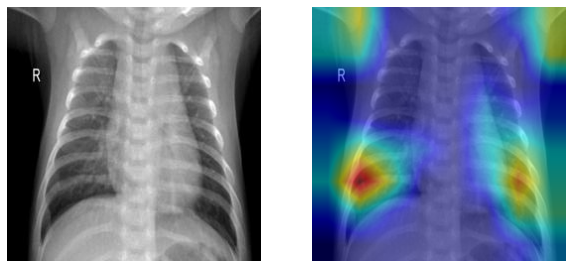

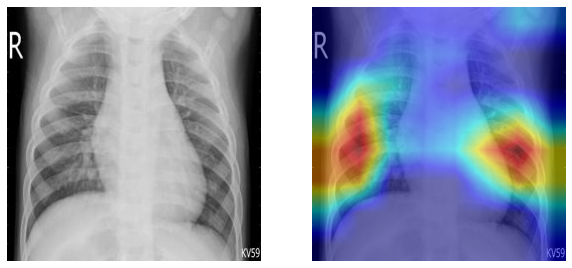

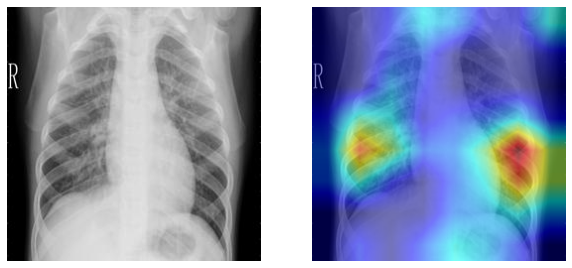

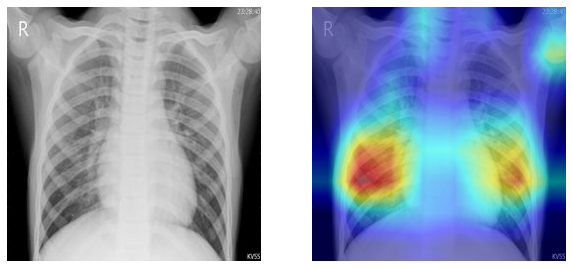

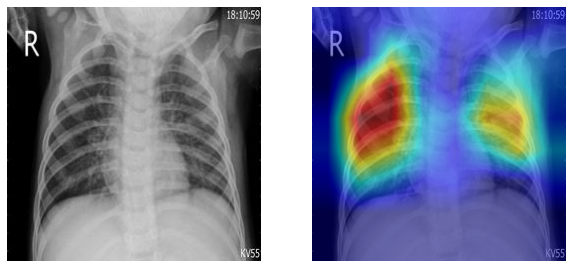

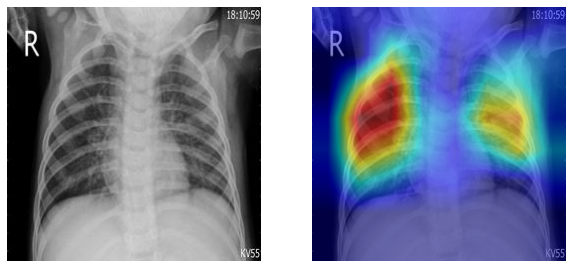

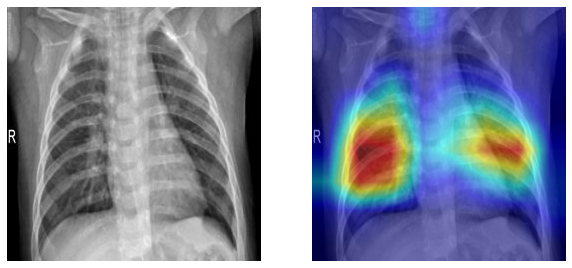

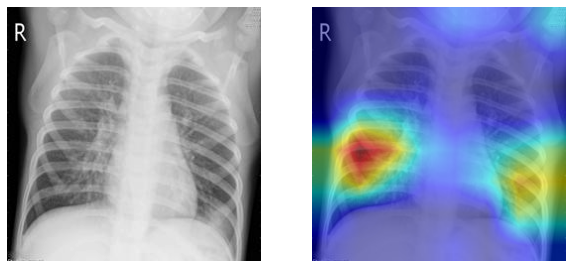

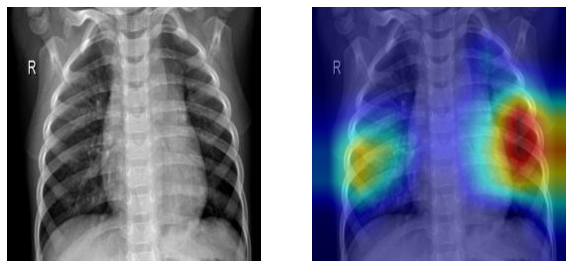

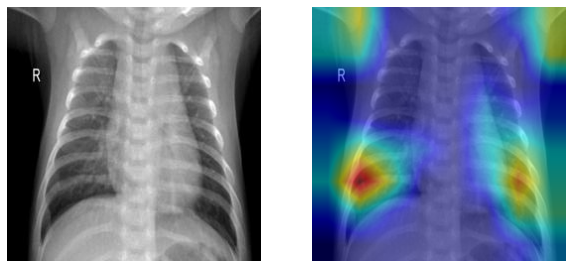

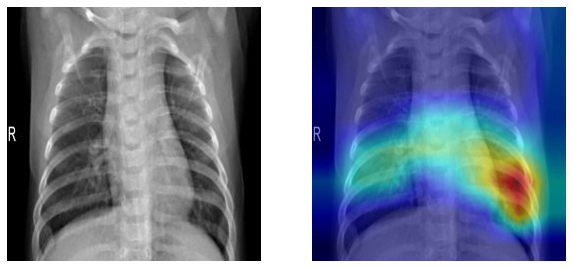

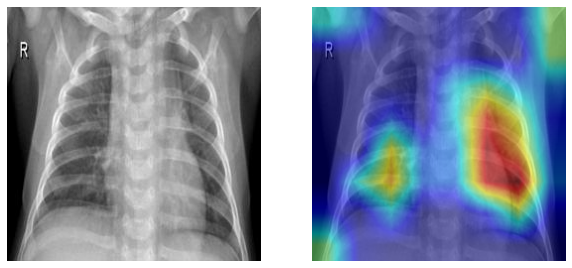

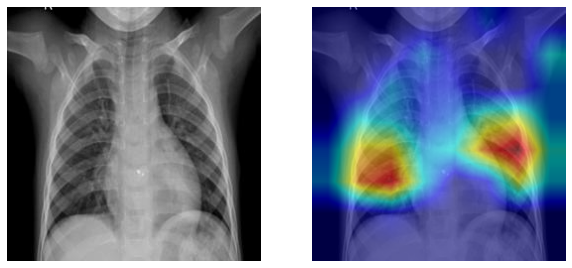

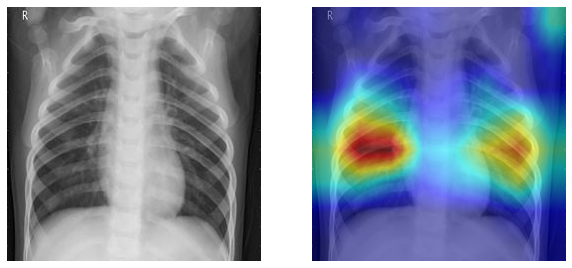

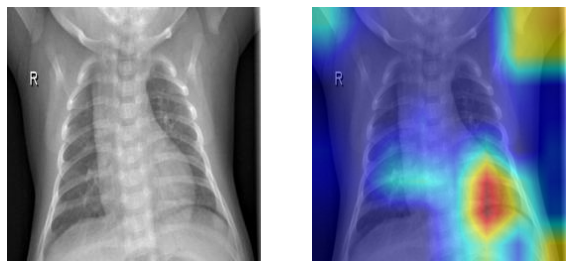

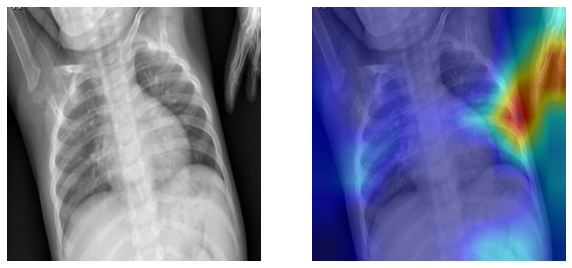

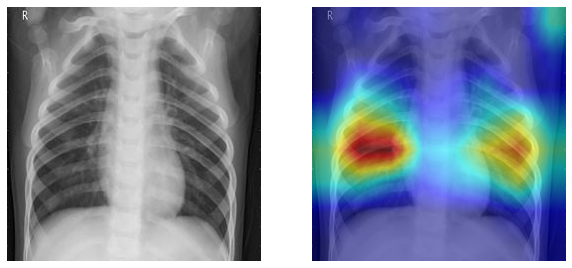

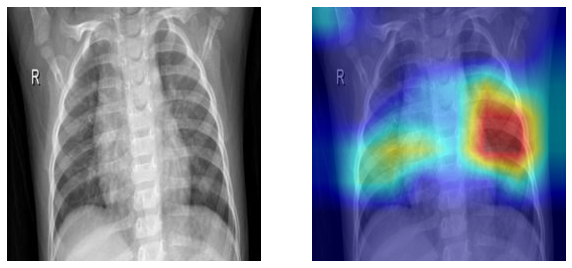

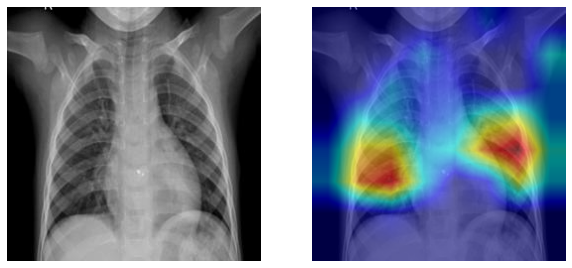

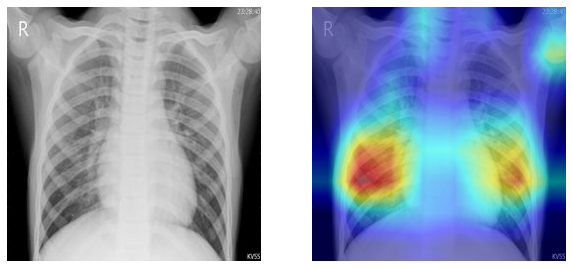

In [87]:
for cam, img in zip(cams, images_tensor):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img, cmap="gray")
    ax[0].axis("off")
    ax[1].imshow(cam)
    ax[1].axis("off")
    fig.show()